In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
from numpy import random

#load data
with sqlite3.connect("database.sqlite") as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

/Users/adysevy/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#select relevant countries and merge with leagues
selected_countries = ['England','France','Germany','Italy','Spain']
countries = countries[countries.name.isin(selected_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))

In [3]:
#select relevant fields
matches = matches[matches.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33
1733,1734,1729,1729,2008/2009,1,2008-08-16 00:00:00,489047,8668,8655,2.00,3.3,4.00


In [4]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

#compute match entropy
matches['entropy'] = matches.apply(match_entropy,axis=1)

In [5]:
#compute mean entropy for every league in every season
entropy_means = matches.groupby(('season','league_id')).entropy.mean()
entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')
entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]
entropy_means.head(10)

,England,France,Germany,Italy,Spain
season,,,,,
2008/2009,0.985462,1.026528,1.004476,1.002100,1.010734
2009/2010,0.956445,1.013726,0.997749,1.006562,0.978531
2010/2011,0.983073,1.026196,1.016482,1.006734,0.974721
2011/2012,0.970060,1.024725,1.001488,1.003185,0.954997
2012/2013,0.981854,1.016093,0.994724,1.003405,0.970283
2013/2014,0.960774,1.004431,0.978929,0.992938,0.944064
2014/2015,0.981162,1.013026,0.986681,0.999356,0.933217
2015/2016,0.997686,1.014130,0.976424,0.985519,0.946479


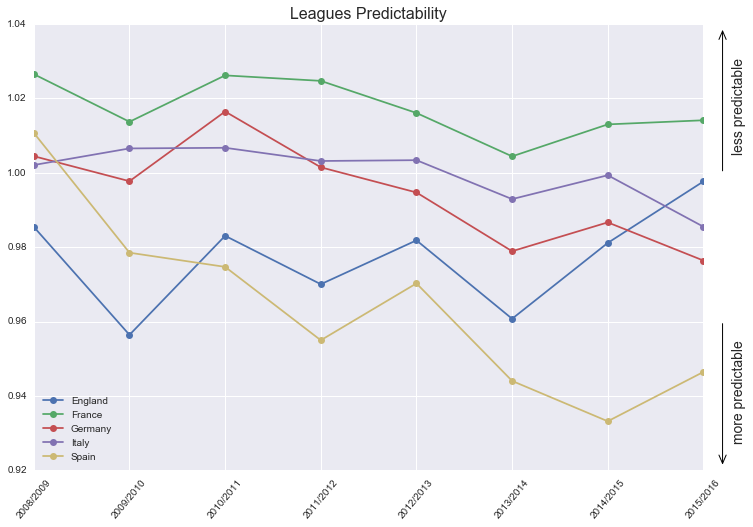

In [9]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

#remove x label
ax.set_xlabel('')

#locate legend 
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

plt.savefig('figures/leagues_pred.png', bbox_inches='tight',dpi=600)

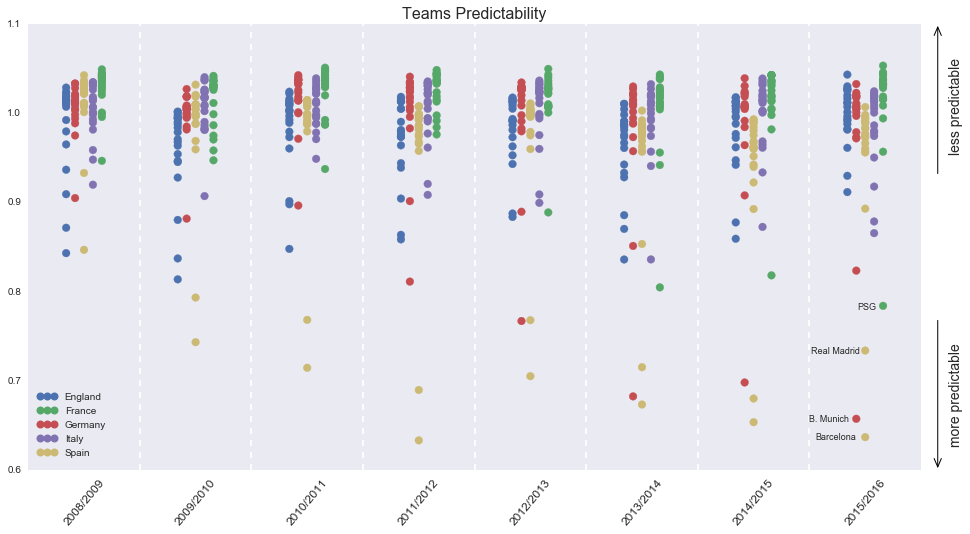

In [10]:
from matplotlib.lines import Line2D


barcelona = teams[teams.team_long_name=='Barcelona'].team_api_id.values[0]
offsets = [-0.16,-0.08,0,0.08,0.16]
offsets_mapping = dict(zip(colors_mapping.keys(),offsets))
y = []
x = []
c = []

i = -1
for season,season_df in matches.groupby('season'):
    i+=1
    for team,name in zip(teams.team_api_id,teams.team_long_name):
        team_df = season_df[(season_df.home_team_api_id==team)|(season_df.away_team_api_id==team)]
        team_entropy = team_df.entropy.mean()
        if team_entropy>0:
            league_id = team_df.league_id.values[0]
            x.append(i+offsets_mapping[league_id])
            y.append(team_entropy)
            c.append(colors_mapping[league_id])

plt.figure(figsize=(16,8))
plt.scatter(x,y,color=c,s=[60]*len(x))
plt.title('Teams Predictability', fontsize=16)

#create ticks and labels
ax = plt.gca()
plt.xlim((-0.5,7.5))
plt.xticks(np.arange(0,8,1),rotation=50)

#create grid
ax.set_xticklabels(entropy_means.index,fontsize=12)
for i in range(7):
    ax.axvline(x=0.5+i,ls='--',c='w')
ax.yaxis.grid(False)
ax.xaxis.grid(False)

#create legend
circles = []
labels = []
for league_id,name in zip(leagues.id,leagues.name):
    labels.append(name)
    circles.append(Line2D([0], [0], linestyle="none", marker="o", markersize=8, markerfacecolor=colors_mapping[league_id]))
plt.legend(circles, labels, numpoints=3, loc=(0.005,0.02))

#add arrows
ax.annotate('', xytext=(7.65, 0.93),xy=(7.65, 1.1),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.65, 0.77),xy=(7.65, 0.6),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.75, 1.05), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.75, 0.73), annotation_clip=False,fontsize=14,rotation='vertical')

#add labels
ax.annotate('Barcelona', xy=(6.55, 0.634),fontsize=9)
ax.annotate('B. Munich', xy=(6.5, 0.655),fontsize=9)
ax.annotate('Real Madrid', xy=(6.51, 0.731),fontsize=9)
ax.annotate('PSG', xy=(6.93, 0.78),fontsize=9)

plt.savefig('figures/teams_pred.png', bbox_inches='tight',dpi=600)





